In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import re
import nltk

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
root_path = '../../archive'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/41591852.py:3: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(metadata_path, dtype={


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
meta_df['source_x'].value_counts()

WHO                                    442286
Medline; PMC                           144205
Medline                                128329
PMC                                     75828
Medline; PMC; WHO                       57283
Elsevier; Medline; PMC                  48719
Medline; WHO                            38774
Elsevier; Medline; PMC; WHO             18006
MedRxiv; WHO                            13505
ArXiv                                   12659
Elsevier; PMC                            8239
Elsevier; PMC; WHO                       6460
PMC; WHO                                 5639
MedRxiv                                  4449
BioRxiv; WHO                             3662
BioRxiv                                  3413
MedRxiv; Medline; PMC; WHO                921
BioRxiv; Medline; PMC; WHO                678
BioRxiv; Medline; WHO                     395
MedRxiv; Medline; WHO                     379
Elsevier                                  287
BioRxiv; MedRxiv                  

In [4]:
all_json = ! ls $root_path/document_parses/pdf_json
len(all_json)

375999

In [5]:
all_json[:5]

['0000028b5cc154f68b8a269f6578f21e31f62977.json',
 '0000b6da665726420ab8ac9246d526f2f44d5943.json',
 '0000b93c66f991236db92dc16fa6db119b27ca12.json',
 '0000fcce604204b1b9d876dc073eb529eb5ce305.json',
 '000122a9a774ec76fa35ec0c0f6734e7e8d0c541.json']

In [6]:
all_json = [root_path + "/document_parses/pdf_json/" + s for s in all_json]
all_json[:5]

['../../archive/document_parses/pdf_json/0000028b5cc154f68b8a269f6578f21e31f62977.json',
 '../../archive/document_parses/pdf_json/0000b6da665726420ab8ac9246d526f2f44d5943.json',
 '../../archive/document_parses/pdf_json/0000b93c66f991236db92dc16fa6db119b27ca12.json',
 '../../archive/document_parses/pdf_json/0000fcce604204b1b9d876dc073eb529eb5ce305.json',
 '../../archive/document_parses/pdf_json/000122a9a774ec76fa35ec0c0f6734e7e8d0c541.json']

In [7]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0000028b5cc154f68b8a269f6578f21e31f62977: ... According to current live statistics at the time of editing this letter, Russia has been the third country in the world to be affected by COVID-19 with both new cases and death rates rising. It remain...


In [8]:
!conda install tqdm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [9]:
from tqdm import tqdm
all_json_clean = list()
for idx, entry in tqdm(enumerate(all_json), total=len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.body_text) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

100%|████████████████████████████████████████████████████████████████| 375999/375999 [06:23<00:00, 980.51it/s]


375671

In [10]:
import random

random.seed(42)

all_json = random.sample(all_json, 1000)

In [11]:
all_json[:5]

['../../archive/document_parses/pdf_json/e4bf914ff5ecb0354592d057a9c65085e2e5551c.json',
 '../../archive/document_parses/pdf_json/27cc1a09b777705b9c31e04946cb5e7c07d9ef77.json',
 '../../archive/document_parses/pdf_json/08fda7c00c1c8172848df107ddc48de16ec1489a.json',
 '../../archive/document_parses/pdf_json/6207e26ce53cc5b810baec60c0ead184cf3eb78a.json',
 '../../archive/document_parses/pdf_json/5756f748eb5e3dae569b6c4568caca120b137b50.json']

In [12]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [13]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.59it/s]


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,e4bf914ff5ecb0354592d057a9c65085e2e5551c,10.1111/psyg.12617,,COVID-19 spreads from person to person through...,"Kobayashi, Ryota. Hayashi, Hiroshi. <br>Kawa...",Recognition of the coronavirus disease 2019<b...,Psychogeriatrics,Not provided.
1,08fda7c00c1c8172848df107ddc48de16ec1489a,10.1002/nadc.19830310520,Mai 12.05.-14.05. Bielefeld Deutsche Bunsen-Ge...,In den funfziger Jahren hat die Impedanzmessun...,NaN,Deutsche Bunsen‐Gesellschaft für<br>Physikali...,NaN,Mai 12.05.-14.05. Bielefeld Deutsche<br>Bunse...
2,6207e26ce53cc5b810baec60c0ead184cf3eb78a,10.1007/s00406-020-01196-x,"Due to the ongoing COVID-19 pandemic, an unpre...",Quarantine and isolation are main containment ...,"Henssler, Jonathan. Stock, Friederike. van<...",Mental health effects of infection<br>contain...,Eur Arch Psychiatry Clin Neurosci,"Due to the ongoing COVID-19 pandemic, an<br>u..."
3,5756f748eb5e3dae569b6c4568caca120b137b50,10.1016/b978-0-7020-2488-7.50022-3,"publicly funded repositories, such as the WHO ...",While weight loss is a common presenting probl...,"Gunn-Moore, Danièlle. Miller, James B",The cat with weight loss and a good appetite,Problem-Based Feline Medicine,"publicly funded repositories, such as the WHO..."
4,4f8cca4f5378dc2cfc32749a8a337bfca48a81e1,10.1016/j.micpath.2020.104452,"M.M, S.M.M, and A.G. drafted the study concept...",Since the first observation of probiotic bacte...,"Mahooti, Mehran. Miri, Seyed Mohammad. <br>A...",The immunomodulatory effects of probiotics on...,Microb Pathog,"M.M, S.M.M, and A.G. drafted the study concep..."


In [14]:
# df_covid['body_text'][2]

# Preprocessing
## Handling multiple languages

In [26]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████████████████████████████████████████████████████████████████| 894/894 [00:04<00:00, 185.13it/s]


In [27]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 894

{'de': 11, 'en': 865, 'es': 9, 'fr': 9}


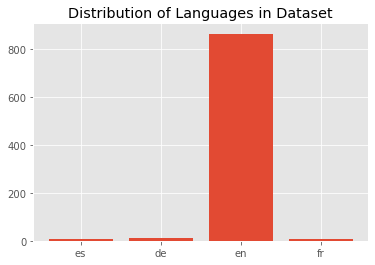

In [28]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [29]:
df = df_covid[df_covid['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 893
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          865 non-null    object
 1   doi               839 non-null    object
 2   abstract          865 non-null    object
 3   body_text         865 non-null    object
 4   authors           851 non-null    object
 5   title             865 non-null    object
 6   journal           788 non-null    object
 7   abstract_summary  865 non-null    object
 8   language          865 non-null    object
dtypes: object(9)
memory usage: 67.6+ KB


## Stopwords

In [30]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['amongst',
 '‘ll',
 'anywhere',
 'whose',
 'you',
 'am',
 'for',
 'few',
 'nor',
 'become']

In [31]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
        
lst_stopwords = stopwords

In [32]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    pat = r'\d+'
    text = re.sub(pat, '', text)
    # r'[^a-zA-z0-9.,!?/:;\"\'\s]
    # r'[^\w\s]
    
    # text = text.replace(r'\d+','')
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    # removed_numbers = dataframe.str.replace(r'\d+','')
        
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [33]:
def apply_preprocess(df):
    df["body_text_clean"] = df["body_text"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [ ]:
df = apply_preprocess(df)
df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/124836987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["body_text_clean"] = df["body_text"].apply(lambda x:


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,body_text_clean
0,e4bf914ff5ecb0354592d057a9c65085e2e5551c,10.1111/psyg.12617,,COVID-19 spreads from person to person through...,"Kobayashi, Ryota. Hayashi, Hiroshi. <br>Kawa...",Recognition of the coronavirus disease 2019<b...,Psychogeriatrics,Not provided.,en,covid spread person person saliva droplet aero...
2,6207e26ce53cc5b810baec60c0ead184cf3eb78a,10.1007/s00406-020-01196-x,"Due to the ongoing COVID-19 pandemic, an unpre...",Quarantine and isolation are main containment ...,"Henssler, Jonathan. Stock, Friederike. van<...",Mental health effects of infection<br>contain...,Eur Arch Psychiatry Clin Neurosci,"Due to the ongoing COVID-19 pandemic, an<br>u...",en,quarantine isolation main containment strategy...
3,5756f748eb5e3dae569b6c4568caca120b137b50,10.1016/b978-0-7020-2488-7.50022-3,"publicly funded repositories, such as the WHO ...",While weight loss is a common presenting probl...,"Gunn-Moore, Danièlle. Miller, James B",The cat with weight loss and a good appetite,Problem-Based Feline Medicine,"publicly funded repositories, such as the WHO...",en,weight loss common presenting problem feline m...
4,4f8cca4f5378dc2cfc32749a8a337bfca48a81e1,10.1016/j.micpath.2020.104452,"M.M, S.M.M, and A.G. drafted the study concept...",Since the first observation of probiotic bacte...,"Mahooti, Mehran. Miri, Seyed Mohammad. <br>A...",The immunomodulatory effects of probiotics on...,Microb Pathog,"M.M, S.M.M, and A.G. drafted the study concep...",en,observation probiotic bacteria elie metchnikof...
5,31d6a29184dbf37731de9537bfdb4b7e2cf8871a,10.3390/ijerph18158121,,The Internet and social media platforms are cr...,"Green, Gizell. Tesler, Riki. Sharon, Cochava","Perceived Efficiency Outcomes, Sources and<br...",Int J Environ Res Public Health,Not provided.,en,internet social medium platform crucial venue ...


In [ ]:
df['body_text_clean'][2]

'quarantine isolation main containment strategy intended help protect public preventing spread contagious disease strategy primarily refer restriction movement limitation personal contact quarantine definition person exposed disease isolation contagious person require separation person infected finding previous research pointed increased risk negative psychological outcome depression anxiety isolation quarantined person equally heightened risk adverse mental health outcome rapid review brook reported increased negative psychological outcome including posttraumatic stress symptom confusion anger person quarantine author concluded important stressor longer quarantine electronic supplementary material online version article doiorgs x contains supplementary material available authorized user duration infection fear frustration boredom inadequate supply inadequate information financial loss stigma finding suggest containment strategy quarantine isolation negative impact psychological outcom

In [ ]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz

In [ ]:
def extract_paper_annotations():
    """
    This function looks at all the papers in the CORD-19 dataset and extract entities
    """
    # Define the list of papers we will process
    #papers = [Path("/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/59eab95c43fdea01481fdbf9bae45dfe28ffc693.json")]
    papers = [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('comm_use_subset/comm_use_subset/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('noncomm_use_subset/noncomm_use_subset/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('custom_license/custom_license/pdf_json/*.json')]
    print (len(papers)) 

    # Load the NLP models
    nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...
    nlp_model_bc5cdr = spacy.load("en_ner_bc5cdr_md") # For diseases

    # The output will be one hashmap associating each paper to its annotations
    output = {}

    # Process all the papers
    for paper in tqdm(papers):
        try:
            # Load the document
            document = json.loads(paper.read_text())

            # Get the ID
            paper_id = document['paper_id']
            
            # Initialise its entry
            output[paper_id] = {}
            output[paper_id]['topics'] = {} # The different topic annotations grouped per type
            
            # Group the text by sections (took more than 9h to process!)
            #section_texts = {}
            #section_texts['abstract'] = []
            #for b in document['abstract']:
            #    section_texts['abstract'].append(b['text'])
            #for b in document['body_text']:
            #    section_texts.setdefault(b['section'], [])
            #    section_texts[b['section']].append(b['text'])

            # Retrieve all the text
            texts = []
            for b in document['abstract']:
                texts.append(b['text'])
            if 'body_text' in document:
                for b in document['body_text']:
                    texts.append(b['text'])
            
            # Process the different sections to extract entities
            #for section,texts in section_texts.items():
            text = '.'.join(texts)
            for nlp_model in [nlp_model_bionlp13cg, nlp_model_bc5cdr]:
                tokens = nlp_model(text)
                for entity in tokens.ents:
                    topic_type = entity.label_
                    topic_value = str(entity.text)
                    output[paper_id]['topics'].setdefault(topic_type, set())
                    output[paper_id]['topics'][topic_type].add(topic_value)
            
        except Exception as e:
            print ('Error with {}'.format(paper))
            print (e)

    # Turn the sets into lists to save them as JSON
    for paper_id in output.keys():
        for topic_type in output[paper_id]['topics'].keys():
            output[paper_id]['topics'][topic_type] = list(output[paper_id]['topics'][topic_type])

    return output

In [71]:
import scispacy
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")
nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...


In [68]:
doc = nlp(df['body_text'][2])

In [69]:
print("TEXT", "START", "END", "ENTITY TYPE")
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

TEXT START END ENTITY TYPE
depression 553 563 DISEASE
anxiety 568 575 DISEASE
adverse mental health outcomes. 667 698 DISEASE
post-traumatic stress symptoms 792 822 DISEASE
confusion 824 833 DISEASE
anger 839 844 DISEASE
infection 1149 1158 DISEASE
frustration 1166 1177 DISEASE
psychosocial stressors 1422 1444 DISEASE
adverse mental health effects seems mandatory 1837 1882 DISEASE
primary infection 5372 5389 DISEASE
JH 6216 6218 CHEMICAL
disorder 6914 6922 DISEASE
depression 9552 9562 DISEASE
anxiety 9564 9571 DISEASE
stress-related disorders 9577 9601 DISEASE
depressive disorders 10072 10092 DISEASE
anxiety 10138 10145 DISEASE
stress-related disorders 10203 10227 DISEASE
stress-related disorders 10881 10905 DISEASE
depression 10941 10951 DISEASE
anxiety 10956 10963 DISEASE
depression 11326 11336 DISEASE
depression 11374 11384 DISEASE
PTSD 11392 11396 DISEASE
non-psychotic 11509 11522 DISEASE
psychological disorder 11524 11546 DISEASE
alcohol 11587 11594 CHEMICAL
depression 11754 11764